# Segmentation de la dentine
## Partie 1: Chargement des données et visualisation en 2D et en 3D

### 1- Configuration de  l'environnement de travail

In [4]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.widgets import Button, Slider
import skimage as ski
import cv2
import scipy.ndimage as nd
from tifffile import imread
import tifffile
import stackview
import imageio.v3 as iio

### 2- Chargement des images

In [5]:
# Charger les images en 3D
stack_3d = imread("/home/experiences/grades/saras/Documents/DATA_SWING/01_processed_data/tomo_sain61_si_dej3/01_crop_data/data_3d/data_3d.tif")
stack_3d = imread("/home/experiences/grades/saras/Documents/DATA_SWING/01_processed_data/tomo_sain61_si_dej3/02_watershed_2d/")


In [6]:
# reshape
stack_3d = np.transpose(stack_3d, (1,2,0))

In [7]:
# Créer un array vide pour la boucle
image_3d = np.zeros_like(stack_3d)
print(image_3d.shape)
borderlow_3d = np.zeros_like(stack_3d)
print(borderlow_3d.shape)

(864, 864, 720)
(864, 864, 720)


In [19]:
# boucle en 3d
for i in range(stack_3d.shape[2]):
    img = stack_3d[:,:,i]
    im_array = np.array(img)
    # Normalisation en 8 bits
    img_norm = ((im_array - im_array.min()) / np.ptp(im_array)) * 255
    img_norm = img_norm.astype(np.uint8)
    border = ski.filters.threshold_yen(img_norm)
    border = img > border
    border = ski.morphology.remove_small_objects(border)
    borderfill = ski.morphology.area_closing(border, area_threshold=10000)
    borderlow = ski.morphology.isotropic_erosion(borderfill, 25)
    imclean = img.copy()
    imclean[~borderlow] = 0

    # image_vide
    image_vide = np.zeros_like(imclean)

    #Watershed
    #Seuil
    seuil_1 = 24000
    seuil_2 = 0
    seuil_3 = 22000
    # Masque binaire avec les pixels [seuil_2 _ seuil2)]
    masque = (imclean > seuil_2) & (imclean < seuil_3)

    # remplissage de l'array avec les seuils
    image_vide[masque] = 2
    image_vide[imclean > seuil_1] = 1
    image_vide[~borderlow] = 0

    image_3d[:,:,i] = image_vide
    borderlow_3d[:,:,i] = borderlow

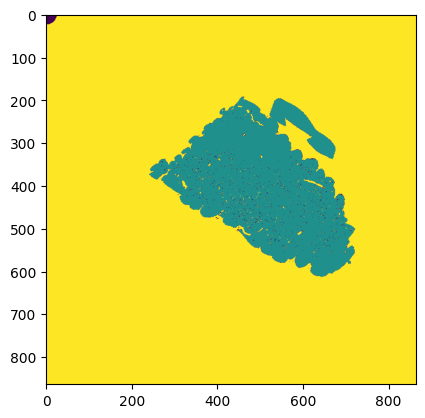

In [20]:
plt.imshow(image_3d[:,:,0])
plt.show()

In [21]:
# Watershed
elem = ski.morphology.disk(5)
watershed_labels = ski.segmentation.watershed(ski.filters.sobel(ski.filters.gaussian(stack_3d,1)), image_3d)

watershed_labels[watershed_labels == 1] = 0
watershed_labels[watershed_labels == 2] = 1

lumiere = borderlow_3d & watershed_labels


In [24]:
lumiere_3d = np.transpose(lumiere, (2,0,1))
lumiere_3d = ~lumiere_3d

In [36]:
print(borderlow_3d.shape)

(864, 864, 720)


In [38]:
borderlow_3d = np.transpose(borderlow_3d, (2,0,1))
borderlow_3d = ~borderlow_3d

In [39]:
# Visualisation interactive avec stackview
stackview.slice(borderlow_3d)

In [25]:
# Visualisation interactive avec stackview
stackview.slice(lumiere_3d)

In [26]:
tifffile.imwrite('/home/experiences/grades/saras/Documents/DATA_SWING/01_processed_data/tomo_sain61_si_dej3/01_3d_watershed/lumiere_3d.tiff', lumiere_3d.astype(np.uint16))

In [40]:
tifffile.imwrite('/home/experiences/grades/saras/Documents/DATA_SWING/01_processed_data/tomo_sain61_si_dej3/01_3d_watershed/borderlow_3d.tiff', borderlow_3d.astype(np.uint16))